In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np

import scipy.linalg as linalg
import PIL.Image as Image
import matplotlib.pyplot as plt

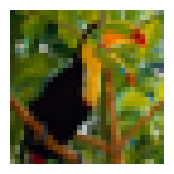

In [2]:
img = Image.open('img_002_SRF_2_LR.png')
img = img.resize((32,32),Image.BICUBIC)
img = np.asarray(img)
# normalize img
img = img/255.0

# plot the image, smaller size without axis
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(img)
ax.axis('off')
plt.show()

In [3]:
C = nn.ConvTranspose2d(32, 3, kernel_size=9, stride=1, padding=4, bias=False)
torch.nn.init.uniform_(C.weight, a=-0.5, b=0.5)

B = nn.ConvTranspose2d(32, 32, kernel_size=9, stride=1, padding=4, bias=False)
torch.nn.init.uniform_(B.weight, a=0., b=1.)

maxpool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)

In [4]:
img = torch.FloatTensor(img).permute(2,0,1).unsqueeze(0)
print("pytorch image shape: ", img.shape)
R = torch.zeros(img.shape[0], 32, 32, 32, requires_grad=True)
Rz = torch.zeros(img.shape[0], 32, 32, 32, requires_grad=True)

u = torch.zeros(img.shape[0], 32, 16, 16, requires_grad=True)
uz = torch.zeros(img.shape[0], 32, 16, 16, requires_grad=True)

old_R = R.clone().detach()
old_u = u.clone().detach()

tkx = 1
tk_1x = 1
tku = 1
tk_1u = 1
mu = 0.01/(32*32*32)
lamb = 0.2
sparse_u = 0.2

xp = R.clone().detach()

xp,inx = maxpool(xp)

index = inx

gama = -B(u).clone().detach()
gama = unpool(gama,inx)
gama = ((1+torch.exp(gama))*lamb)       


lossx = []
lossu = []

m4u = 0

protect_x = 0
protect_u = 0
for m in range(200):
    
    
    Lx = torch.ones((1, 1 ,1 ,1))
    Lu = torch.ones((1, 1, 1, 1))
    
    #infer states

    pred_z = C(Rz)  
    const = ((img - pred_z) ** 2).sum((-1,-2,-3)) 
    const.sum().backward()
    const = const.data.clone().detach()
    grad_zk = (Rz.grad.data.clone().detach())
    stop_linesearch = torch.zeros((1, 1))
    zero_tensor = torch.zeros(Rz.shape)
    keep_going = 1
    
    while keep_going and protect_x<20000:#torch.sum(stop_linesearch) != batch_size: # search step size using lipschitz condition        
        gk = Rz - grad_zk/Lx
        R.data = (torch.sign(gk)*(torch.max((torch.abs(gk)-gama/Lx),zero_tensor))).clone() #soft thresholding
        pred = C(R)
        temp1 = ((img - pred) ** 2).sum((-1,-2,-3))#
        temp2 = const +((R - Rz)*grad_zk).sum((-1,-2,-3))+((Lx/2).sum((-1,-2,-3)))*(((R - Rz)**2).sum((-1,-2,-3)))
        stop_linesearch[temp1<= temp2] = True
        decay = torch.ones((1, 1))
        decay = (1-stop_linesearch)*2
        decay[decay==0] = 1
        Lx = Lx*decay.unsqueeze(-1).unsqueeze(-1)
        protect_x+=1
        if (temp1.sum())<= (temp2.sum()):
            keep_going = 0

        
    tk_1x = 1+((((m+1))**8-1)/2) # the major contribution: Faster Fista step
    Rz.data = (R.clone().detach() + (tkx - 1)/(tk_1x)*(R.clone().detach() - old_R)).clone()
    old_R = R.clone().detach()
    tkx = tk_1x
    Rz.grad.zero_()
    # prox
    lossx.append(temp1.cpu().detach().numpy())
    
    
    # max pool the states and get pooled state xp.
    xp = R.clone().detach()
    xp,inx = maxpool(xp)
    index = inx 

    #infer causes.
    
    for u_iter in range(1):
        pred_uz = (1+torch.exp(-B(uz)))*lamb - lamb
        const = (pred_uz * torch.abs(xp)).sum((-1,-2,-3))# + (td_alpha*(self.uz - td)**2).sum((-1,-2,-3))
        const.sum().backward()
        const = const.data.clone().detach()
        grad_zk = (uz.grad.data.clone().detach())
        stop_linesearch = torch.zeros((1, 1))
        zero_tensor = torch.zeros(uz.shape)
        keep_going = 1
        while keep_going and protect_u<20000:#torch.sum(stop_linesearch) != batch_size:# search step size using lipschitz condition
            gk = uz - grad_zk/Lu
            u.data = (torch.sign(gk)*(torch.max((torch.abs(gk)-sparse_u/Lu),zero_tensor))).clone() #soft thresholding
            pred = (1+torch.exp(-B(u)))*lamb - lamb
            temp1 = (pred * torch.abs(xp)).sum((-1,-2,-3))# + (td_alpha*(self.u - td)**2).sum((-1,-2,-3))
            temp2 = const+((u - uz)*grad_zk).sum((-1,-2,-3))+((Lu/2).sum((-1,-2,-3)))*(((u - uz)**2).sum((-1,-2,-3)))
            stop_linesearch[temp1<= temp2] = True
            decay = torch.ones((1, 1))
            decay = (1-stop_linesearch)*2
            decay[decay==0] = 1
            Lu = Lu*decay.unsqueeze(-1).unsqueeze(-1)
            protect_u+=1 
            
            if (temp1.sum())<= (temp2.sum()):
                keep_going = 0
            
        sparse_u = np.maximum(0.985*sparse_u,1e-3)#0.975-100
        tk_1u = 1+((((m4u+1))**8-1)/2) # the major contribution: Faster Fista step
        uz.data = (u.clone().detach() + (tku - 1)/(tk_1u)*(u.clone().detach() - old_u)).clone()
        old_u = u.clone().detach()
        tku = tk_1u
        

        lossu.append(temp1.cpu().detach().numpy())

        uz.grad.zero_()
        m4u += 1
    
    # infer the L1 coefficient of states gama based on B and u.
    gama = -B(u).clone().detach()
    gama = unpool(gama,inx)
    gama = ((1+torch.exp(gama))*lamb)

pytorch image shape:  torch.Size([1, 3, 32, 32])


min R loss:  1.35621 min u loss:  0.07562875


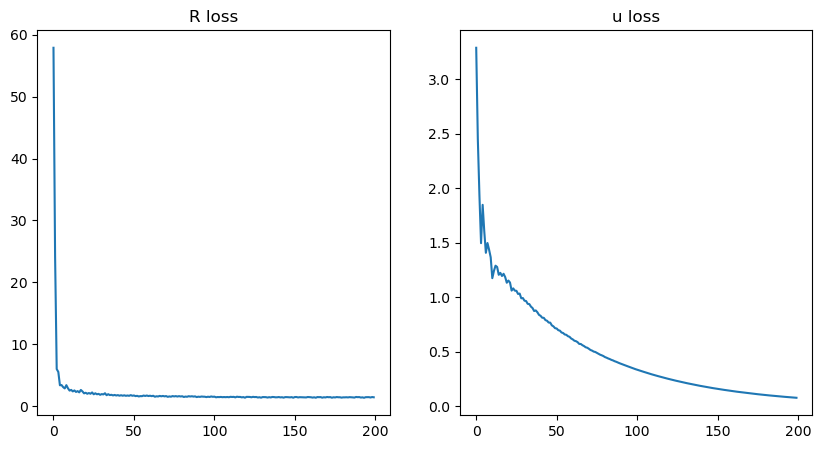

In [5]:
# Plot R and u loss
print("min R loss: ", np.min(lossx), "min u loss: ", np.min(lossu))
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(lossx)
ax[0].set_title('state loss')
ax[1].plot(lossu)
ax[1].set_title('u loss')
plt.show()

In [6]:
print("min max of R: ", R.data.min(), R.data.max())
print("min max of u: ", u.data.min(), u.data.max())

min max of R:  tensor(-0.1875) tensor(0.3302)
min max of u:  tensor(0.) tensor(0.8368)


recon image shape: torch.Size([1, 3, 32, 32]) 
min, max: tensor(-0.0341) tensor(0.9696)


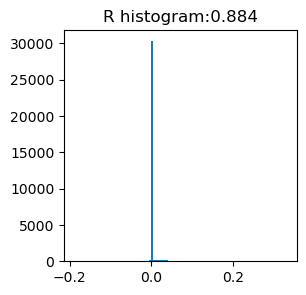

In [7]:
recon = C(R)
print("recon image shape:", recon.shape, "\nmin, max:", recon.data.min(), recon.data.max())
recon_u = C(unpool(B(u), index))

# plot the histogram of R
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(R.detach().numpy().flatten(), bins=100)
# calculate ratio of 0 elements in R
ax.set_title(f'R histogram:{(R==0).sum().item()/R.numel():.3f}')
plt.show()

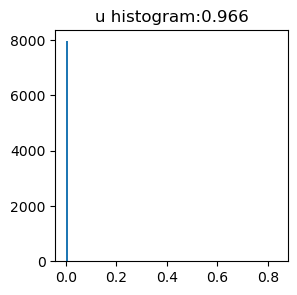

u shape: torch.Size([1, 32, 16, 16]) 
min, max: tensor(0.) tensor(0.8368)


In [8]:
# do the same for u
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(u.detach().numpy().flatten(), bins=100)
ax.set_title(f'u histogram:{(u==0).sum().item()/u.numel():.3f}')
plt.show()

print("u shape:", u.shape, "\nmin, max:", u.data.min(), u.data.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Recon U')

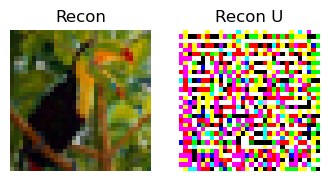

In [9]:
# plot recon as an image
recon = recon.squeeze().permute(1,2,0).detach().numpy()
# actually plot both recons side by side
fig, ax = plt.subplots(1,2,figsize=(4,2))
ax[0].imshow(recon)
ax[0].axis('off')
ax[0].set_title("Recon")
ax[1].imshow(recon_u.squeeze().permute(1,2,0).detach().numpy())
ax[1].axis('off')
ax[1].set_title("Recon U")


In [10]:
print("recon u min, max: ", recon_u.data.min(), recon_u.data.max())

recon u min, max:  tensor(-108.0236) tensor(158.7729)
